# Import Library and Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [ ]:
customer_data = pd.read_csv("/content/drive/MyDrive/CSNam3HUCEStudents/MachineLearning/NaiveBayesAndKMean/code/Kmeans/Mall_Customers.csv")

# Feature Engineering

In [ ]:
# convert data frame to array['Gender', 'Age', 'Annual Income', 'Spending Score (1-100)']
X = customer_data.iloc[:, [1, 2, 3, 4] ].values 
X.shape

(200, 4)

In [ ]:
#Encoding 'Gender' column from categorical to numerical values
for i in range(len(X)):
  if X[i][0] == 'Male':
    X[i][0]  =  1
  else:
    X[i][0]  =  0

In [ ]:
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
customer_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

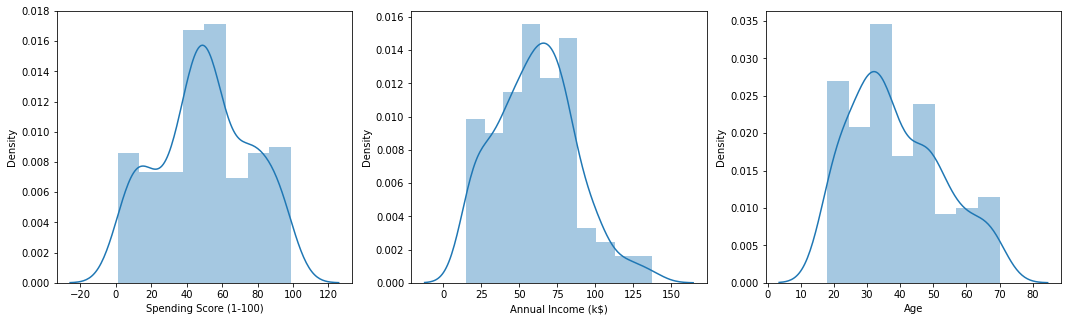

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(18,5))
sns.distplot(customer_data['Spending Score (1-100)'],ax=axes[0])
sns.distplot(customer_data["Annual Income (k$)"],ax=axes[1])
sns.distplot(customer_data["Age"],ax=axes[2])
plt.show()

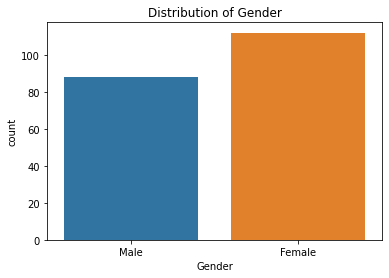

In [ ]:
# See the distribution of gender to recognize different distributions
sns.countplot(x='Gender', data=customer_data);
plt.title('Distribution of Gender');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


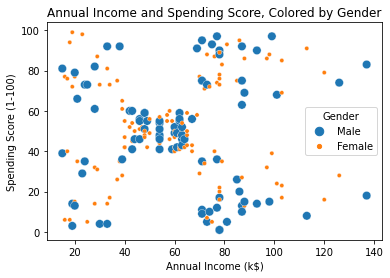

In [ ]:
# de dang nhan thay duoc xu huong o day
# average income, averge spending score
# low income, low spending score
# co the co 2 cum (k=2) hoac phan tich ki hon se co the co 5 cum
sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', hue='Gender', data=customer_data, size="Gender");
plt.title('Annual Income and Spending Score, Colored by Gender');

**Nhìn đồ thị trên có thể thấy có thể phân 5 cụm**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


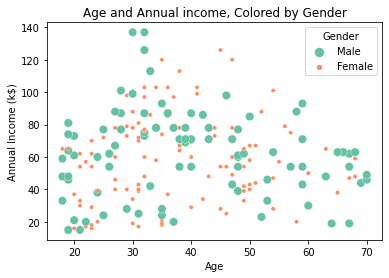

In [ ]:
sns.scatterplot('Age', 'Annual Income (k$)', hue='Gender', data=customer_data, palette="Set2", size="Gender")
plt.title('Age and Annual income, Colored by Gender');

# K-means++ Algorithm

In [ ]:
#Viết hàm khởi tạo điểm trung tâm ngẫu nhiên
def init_centroids(X, k):
  #Lấy ngẫu nhiên k điểm trung tâm trong X
  #return X[np.random.choice(X.shape[0], k, replace=False)]
   ## Lay ngau nhien diem trung tam dau tien
    centroids = []
    centroids.append(X[np.random.choice(X.shape[0], replace=False)])
    
    ## Tinh k-1 diem trung tam con lai
    for c_id in range(k - 1):
        ## points from nearest centroid
        dist = []
        for i in range(X.shape[0]):
            point = X[i, :]
            d = sys.maxsize
        
            ## selected centroid and store the minimum distance
            for j in range(len(centroids)):
                temp_dist = np.linalg.norm(point - centroids[j])
                d = min(d, temp_dist)
            dist.append(d)
             
        ## chọn điểm dữ liệu với khoảng cách tối đa làm trung tâm tiếp theo
        dist = np.array(dist)
        next_centroid = X[np.argmax(dist), :]
        centroids.append(next_centroid)
        dist = []
    return centroids
  
def assign_labels(X, centroids, k):
  clusters = {}
  #Khởi tạo các cluster trống
  for i in range(k):
    clusters[i] = []
  for featureset in X:
    #Tính khoảng cách từ điểm featureset đến từng điểm trung tâm
    distances = [np.linalg.norm(featureset - centroid) for centroid in centroids]
    cluster = distances.index(min(distances))
    clusters[cluster].append(featureset) 
  return clusters

def update_centroids(clusters):
  new_centroids = []
  for cluster, datapoints in clusters.items():
    new_centroids.append(np.average(datapoints, axis=0))
  return new_centroids

def has_converged(centers, new_centers):
  # Hội tụ khi các điểm trung tâm không thay đổi
  return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [ ]:
def K_means(k):
  centroids = init_centroids(X, k) 
  while True:
    clusters = assign_labels(X, centroids, k)
    new_centroids = update_centroids(clusters)
    if has_converged(centroids, new_centroids):
      break
    centroids = new_centroids

  X_, labels = visualize(clusters)
  wcss = find_within_cluster_sum_of_square(X_, labels, k, centroids)

  return (X_, labels, wcss)

In [ ]:
def visualize(clusters):
  #Visualization
  X_ = []
  labels = []

  for cluster, datapoints in clusters.items():
    for datapoint in datapoints:
      X_.append(datapoint)
      labels.append(cluster)

  return (X_, labels)

# Clustering

In [ ]:
def find_within_cluster_sum_of_square(X_, labels, k, centroids):
  wcss = 0
  for i in range(k):
    for x in np.array(X_)[np.array(labels) == i, :]:
      wcss += np.linalg.norm(x - centroids[i])**2
      
  return wcss

In [ ]:
def find_optimal_k():
  #elbow
  list_wcss  = []
  list_labels = []
  list_X_     = []
  list_min_wcss = []

  for i in range(12):
    k= i+1
    for i in range(12):
      X_, labels, wcss = K_means(k)
      list_wcss.append(wcss)
      list_labels.append(labels)
      list_X_.append(X_)
    list_min_wcss.append(min(list_wcss))
    
  return (list_min_wcss,list_X_,list_wcss,list_labels)

In [ ]:
list_min_wcss, list_X, list_wcss, list_labels = find_optimal_k()

In [ ]:
def plot_elbow( list_min_wcss ):
  k_range = list(range(1,13))
  plt.plot(k_range, list_min_wcss,color ='blue', marker='o')
  plt.axis([0,13, 0,350000]) # set axis 
  plt.xlabel("Clusters")
  plt.ylabel("Sum of square distances")

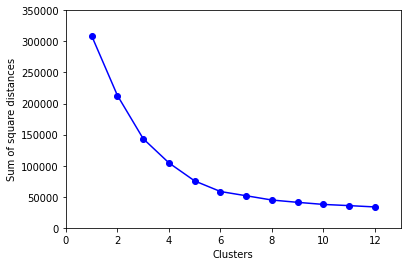

In [ ]:
plot_elbow(list_min_wcss)

Sau khi xét biểu đồ giữa tổng khoảng cách bình phương và số cụm, ta có thể thấy số cụm tối ưu là 5

In [ ]:
# Choose K = 5
min_choose = list_min_wcss[4]
index = list_wcss.index(min_choose)

X0 = np.array(list_X[index])[np.array(list_labels[index])==0,:]
X1 = np.array(list_X[index])[np.array(list_labels[index])==1,:]
X2 = np.array(list_X[index])[np.array(list_labels[index])==2,:]
X3 = np.array(list_X[index])[np.array(list_labels[index])==3,:]
X4 = np.array(list_X[index])[np.array(list_labels[index])==4,:]

# Visualize

Text(0, 0.5, 'Spending Score')

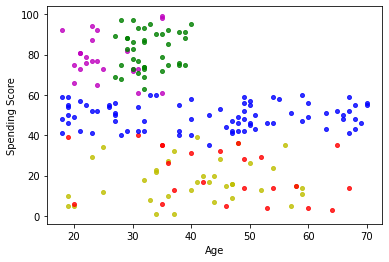

In [ ]:
#Age - Spending Score(1-100)
plt.plot(X0[:, 1], X0[:, 3],'yo', markersize = 4, alpha = .8)
plt.plot(X1[:, 1], X1[:, 3],'mo', markersize = 4, alpha = .8) 
plt.plot(X2[:, 1], X2[:, 3],'ro', markersize = 4, alpha = .8) 
plt.plot(X3[:, 1], X3[:, 3],'go', markersize = 4, alpha = .8)
plt.plot(X4[:, 1], X4[:, 3],'bo', markersize = 4, alpha = .8)
plt.xlabel("Age")
plt.ylabel("Spending Score")

Text(0, 0.5, 'Annual Income(k$)')

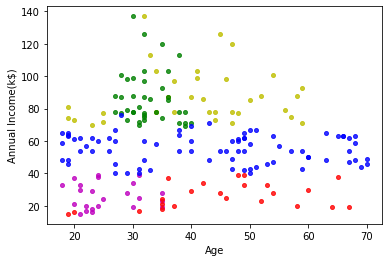

In [ ]:
#Age - Annual Income(k$)
plt.plot(X0[:, 1], X0[:, 2],'yo', markersize = 4, alpha = .8)
plt.plot(X1[:, 1], X1[:, 2],'mo', markersize = 4, alpha = .8) 
plt.plot(X2[:, 1], X2[:, 2],'ro', markersize = 4, alpha = .8) 
plt.plot(X3[:, 1], X3[:, 2],'go', markersize = 4, alpha = .8)
plt.plot(X4[:, 1], X4[:, 2],'bo', markersize = 4, alpha = .8)
plt.xlabel("Age")
plt.ylabel("Annual Income(k$)")

Text(0, 0.5, 'Spending Score')

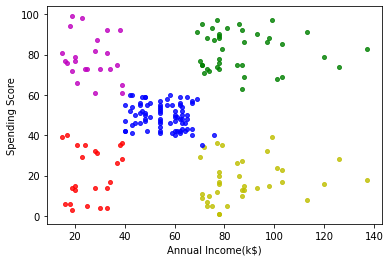

In [ ]:
#Annual Income(k$) - Spending Score(1-100)
plt.plot(X0[:, 2], X0[:, 3],'yo', markersize = 4, alpha = .8)
plt.plot(X1[:, 2], X1[:, 3],'mo', markersize = 4, alpha = .8) 
plt.plot(X2[:, 2], X2[:, 3],'ro', markersize = 4, alpha = .8) 
plt.plot(X3[:, 2], X3[:, 3],'go', markersize = 4, alpha = .8)
plt.plot(X4[:, 2], X4[:, 3],'bo', markersize = 4, alpha = .8)
plt.xlabel("Annual Income(k$)")
plt.ylabel("Spending Score")

# Visualize 3D

In [ ]:
X0 = np.array(list_X[index])[np.array(list_labels[index])==0,:]
X1 = np.array(list_X[index])[np.array(list_labels[index])==1,:]
X2 = np.array(list_X[index])[np.array(list_labels[index])==2,:]
X3 = np.array(list_X[index])[np.array(list_labels[index])==3,:]
X4 = np.array(list_X[index])[np.array(list_labels[index])==4,:]

In [ ]:
#customer_data['Cluster Label'] = y

In [ ]:
cluster_0 = np.hstack((X0, np.zeros((X0.shape[0], 1), dtype= X0.dtype)))
cluster_1 = np.hstack((X1, np.ones((X1.shape[0], 1), dtype= X1.dtype)))
cluster_2 = np.hstack(   (X2, np.full(shape= (X2.shape[0], 1), fill_value=2))  )
cluster_3 = np.hstack(   (X3, np.full(shape= (X3.shape[0], 1), fill_value=3))  )
cluster_4 = np.hstack(   (X4, np.full(shape= (X4.shape[0], 1), fill_value=4))  )
clustering_customer_data = np.concatenate( (cluster_0, cluster_1, cluster_2, cluster_3, cluster_4), axis = 0 )

In [ ]:
clustering_customer_data = pd.DataFrame(data = clustering_customer_data)

In [ ]:
clustering_customer_data = clustering_customer_data.set_axis(['Gender', 'Age', 'Annual Income (k$)'	
                                                              ,'Spending Score (1-100)', 'Label'], axis=1, inplace=False)

In [ ]:
import plotly.express as px
df = clustering_customer_data
fig = px.scatter_3d(df, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)',  color='Label')
fig.show()

In [ ]:
clustering_customer_data

,Gender,Age,Annual Income (k$),Spending Score (1-100),Label
0,0,23,70,29,0
1,1,59,71,11,0
2,1,47,71,9,0
3,0,25,72,34,0
4,1,20,73,5,0
...,...,...,...,...,...
195,1,27,67,56,4
196,0,38,67,40,4
197,0,40,69,58,4
198,1,43,71,35,4


In [ ]:
clustering_customer_data_0 = clustering_customer_data.loc[(clustering_customer_data['Label']==0)]
clustering_customer_data_1 = clustering_customer_data.loc[(clustering_customer_data['Label']==1)]
clustering_customer_data_2 = clustering_customer_data.loc[(clustering_customer_data['Label']==2)]
clustering_customer_data_3 = clustering_customer_data.loc[(clustering_customer_data['Label']==3)]
clustering_customer_data_4 = clustering_customer_data.loc[(clustering_customer_data['Label']==4)]

In [ ]:
clustering_customer_data_0.drop(['Label'], axis=1).astype(int).describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,36.000000,36.000000,36.000000,36.000000
mean,0.527778,40.666667,87.750000,17.583333
std,0.506309,11.496583,16.387059,10.204691
min,0.000000,19.000000,70.000000,1.000000
25%,0.000000,34.000000,77.000000,10.000000
50%,1.000000,41.500000,83.000000,16.000000
75%,1.000000,47.250000,97.250000,24.500000
max,1.000000,59.000000,137.000000,39.000000


In [ ]:
clustering_customer_data_1.drop(['Label'], axis=1).astype(int).describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,23.000000,23.000000,23.000000,23.000000
mean,0.391304,25.521739,26.304348,78.565217
std,0.499011,5.273170,7.893811,10.953729
min,0.000000,18.000000,15.000000,61.000000
25%,0.000000,21.500000,19.500000,73.000000
50%,0.000000,24.000000,25.000000,77.000000
75%,1.000000,30.000000,33.000000,84.500000
max,1.000000,35.000000,39.000000,99.000000


In [ ]:
clustering_customer_data_2.drop(['Label'], axis=1).astype(int).describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,23.000000,23.000000,23.000000,23.000000
mean,0.391304,45.217391,26.304348,20.913043
std,0.499011,13.228607,7.893811,13.017167
min,0.000000,19.000000,15.000000,3.000000
25%,0.000000,35.500000,19.500000,9.500000
50%,0.000000,46.000000,25.000000,17.000000
75%,1.000000,53.500000,33.000000,33.500000
max,1.000000,67.000000,39.000000,40.000000


In [ ]:
clustering_customer_data_3.drop(['Label'], axis=1).astype(int).describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,39.000000,39.000000,39.000000,39.000000
mean,0.461538,32.692308,86.538462,82.128205
std,0.505035,3.728650,16.312485,9.364489
min,0.000000,27.000000,69.000000,63.000000
25%,0.000000,30.000000,75.500000,74.500000
50%,0.000000,32.000000,79.000000,83.000000
75%,1.000000,35.500000,95.000000,90.000000
max,1.000000,40.000000,137.000000,97.000000


In [ ]:
clustering_customer_data_4.drop(['Label'], axis=1).astype(int).describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,79.000000,79.000000,79.000000,79.000000
mean,0.417722,43.088608,55.291139,49.569620
std,0.496335,16.478572,8.710665,6.242295
min,0.000000,18.000000,40.000000,35.000000
25%,0.000000,27.000000,48.000000,44.500000
50%,0.000000,47.000000,54.000000,50.000000
75%,1.000000,54.500000,62.000000,55.000000
max,1.000000,70.000000,76.000000,60.000000
